https://www.kaggle.com/datasets/paultimothymooney/blood-cells
- 오버피팅을 줄이면서 90% 이상의 정확도를 가지는 아키텍쳐 구현

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Project-1

- Goal: ImageDataGenerator와 TL을 이용해서 오버피팅이 최소가 될 수 있도록 90% 이상의 정확도 달성
- 만약 오버피팅이 심하고 90% 이상의 성능이 나오지 않는다면, 문제점과 해결 방안을 찾아본다.

### 경로 설정

In [4]:
# colab
# ROOT_DIR='/content'
# loocal
ROOT_DIR='content'

DATA_ROOT_DIR= os.path.join(ROOT_DIR, 'blood_cell')
TRAIN_DATA_ROOT_DIR= os.path.join(DATA_ROOT_DIR, 'TRAIN')
TEST_SIMPLE_DATA_ROOT_DIR= os.path.join(DATA_ROOT_DIR, 'TEST_SIMPLE')
TEST_DATA_ROOT_DIR= os.path.join(DATA_ROOT_DIR, 'TEST')

### 데이터셋 가져오기

In [ ]:
#### Colab
from google.colab import drive

drive.mount('/content/')

shutil.copy(os.path.join('/content/MyDrive/ColabNotebooks/','blood_cell.zip'), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'blood_cell.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [5]:
#### PC
if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'blood_cell.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

### 정답 및 전체 데이터 갯수 확인

In [6]:
#### 훈련 데이터 갯수
# list= os.listdir(TRAIN_DATA_ROOT_DIR)
# for file in list:
#     print(len(os.listdir(TRAIN_DATA_ROOT_DIR+'/'+file)))

train_label_name_list= os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))
          
print('=================================')
#### 테스트 데이터 갯수

test_label_name_list= os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name))))

print('=================================')
#### Validation 데이터 갯수

test_label_name_list= os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
train label:  EOSINOPHIL => 2497
train label:  LYMPHOCYTE => 2483
train label:  MONOCYTE => 2478
train label:  NEUTROPHIL => 2499
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
train label:  EOSINOPHIL => 13
train label:  LYMPHOCYTE => 6
train label:  MONOCYTE => 4
train label:  NEUTROPHIL => 48
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
train label:  EOSINOPHIL => 623
train label:  LYMPHOCYTE => 620
train label:  MONOCYTE => 620
train label:  NEUTROPHIL => 624


### Image Shape 설정

In [8]:
IMG_WIDTH= 100 # Colab에선 224
IMG_HEIGHT= 100

In [ ]:
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
for label_name in label_name_list:
    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    #=========================================================
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR,label_name)  
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR,label_name)  
    #=========================================================

    train_data_file_list = os.listdir(src_dir_path)
    print('========================================================================')
    print('total [%s] data file nums => [%s]' % (label_name ,
                                                 len(train_data_file_list)))

    # data shuffle
    np.random.shuffle(train_data_file_list)
    print('train data shuffle is done !!!')

    split_num = int(MOVE_RATIO*len(train_data_file_list))
    print('split nums => ', split_num)

    # extract test data from train data
    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0
    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))   
        except Exception as err:
            print(str(err))

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')

### ImageDataGenerator 를 이용하여 데이터 불러오기

In [10]:
IMG_WIDTH= 100 # Colab에선 224
IMG_HEIGHT= 100

train_datagen= ImageDataGenerator(rescale= 1./255, validation_split=0.2)
val_datagen= ImageDataGenerator(rescale= 1./255, validation_split=0.2)
test_datagen= ImageDataGenerator(rescale= 1./255)

test_simple_datagen= ImageDataGenerator(rescale= 1./255)

train_generator= train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, 
                                                batch_size=32,
                                                color_mode='rgb',
                                                shuffle= True, 
                                                target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                class_mode='sparse',
                                                   subset= 'training')

val_generator= val_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True, 
                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                              class_mode='sparse',
                                                 subset= 'validation')

test_generator= test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True, 
                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                              class_mode='sparse')

test_simple_generator= test_simple_datagen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True, 
                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                              class_mode='sparse')

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [17]:
print(train_generator.class_indices)
print(test_generator.num_classes)

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
4


### 16장의 이미지 확인
- ImageDataGenerator를 통해 전달된 이미지 출력

In [15]:
data, label= train_generator.next()

data= data[:16]
label= label[:16]

print(data.shape, label.shape) 
print(label)

(16, 100, 100, 3) (16,)
[3. 2. 2. 0. 0. 2. 2. 3. 3. 2. 3. 3. 1. 2. 3. 2.]


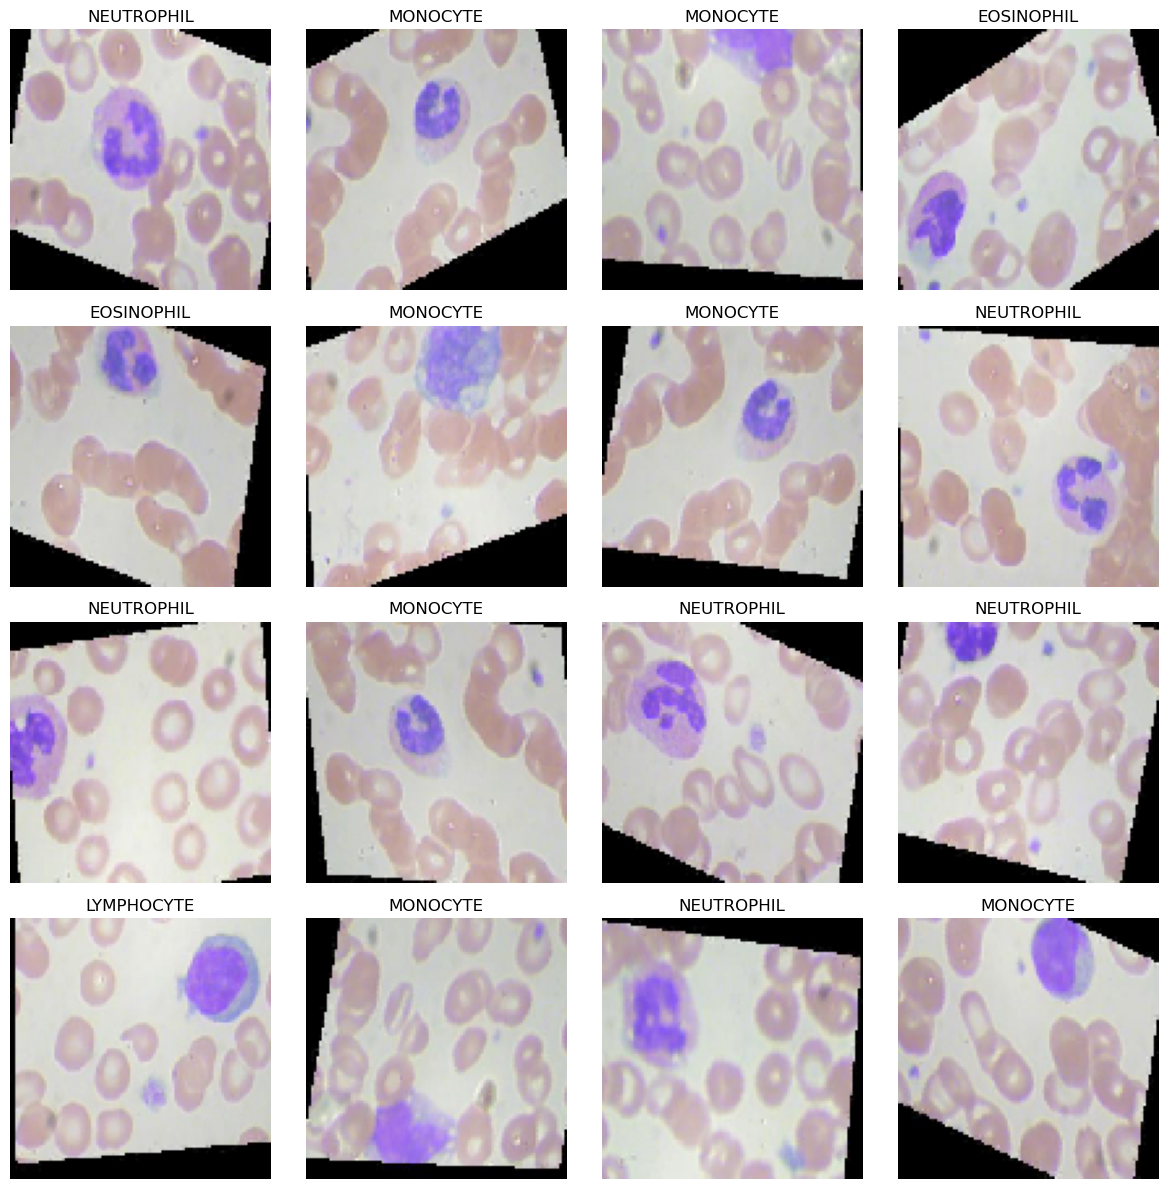

In [18]:
plt.figure(figsize=(12,12))

class_dict={0:'EOSINOPHIL', 1:'LYMPHOCYTE', 2:'MONOCYTE', 3:'NEUTROPHIL'}

for i in range(len(label)):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [19]:
pre_trained_model= MobileNet(weights='imagenet', include_top=False,
                            input_shape= (IMG_WIDTH, IMG_HEIGHT,3))
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [20]:
model= Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 3,360,580
Trainable params: 3,338,692
Non-

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4), metrics=['acc']) # colab: lr=2e-5

In [22]:
start_time= datetime.now()

result= model.fit(train_generator, epochs=3, validation_data=val_generator) # colab: epoch=30
end_time= datetime.now()
print('걸린시간: ', end_time - start_time)

Epoch 1/3
249/249 [==============================] - 148s 576ms/step - loss: 1.1128 - acc: 0.5939 - val_loss: 0.4904 - val_acc: 0.8130
Epoch 2/3
249/249 [==============================] - 103s 412ms/step - loss: 0.2945 - acc: 0.8909 - val_loss: 0.1740 - val_acc: 0.9336
Epoch 3/3
249/249 [==============================] - 107s 430ms/step - loss: 0.1179 - acc: 0.9578 - val_loss: 0.1012 - val_acc: 0.9618
걸린시간:  0:05:58.176728


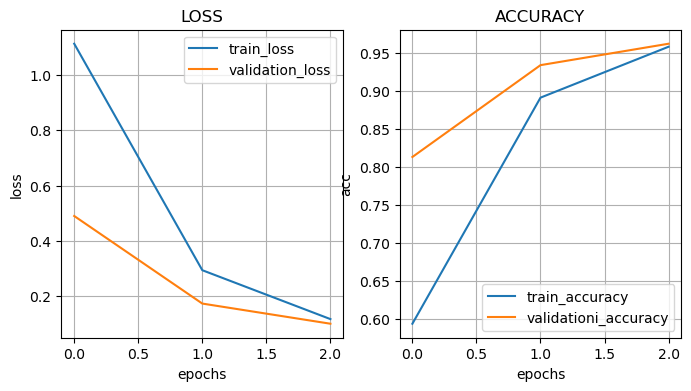

In [23]:
#### 그래프
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

In [34]:
model.evaluate(test_generator)

20/20 [==============================] - 7s 338ms/step - loss: 1.4174 - acc: 0.7212


[1.4173808097839355, 0.7211538553237915]

In [38]:
test_simple_datagen= ImageDataGenerator(rescale= 1./255)

In [39]:
test_simple_generator= test_simple_datagen.flow_from_directory(directory=VAL_DATA_ROOT_DIR, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True, 
                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                              class_mode='sparse')

Found 16 images belonging to 2 classes.


In [40]:
model.evaluate(test_simple_generator)

1/1 [==============================] - 0s 203ms/step - loss: 1.1141 - acc: 0.6875


[1.1141178607940674, 0.6875]

1425
3846
['NORMAL', 'PNEUMONIA']
train label:  NORMAL => 1425
train label:  PNEUMONIA => 3846
['NORMAL', 'PNEUMONIA']
train label:  NORMAL => 158
train label:  PNEUMONIA => 427
===========train으로 MOVE============
['NORMAL', 'PNEUMONIA']
158 is moved into NORMAL
427 is moved into PNEUMONIA
0 is moved into NORMAL
0 is moved into PNEUMONIA
==========train 전체 데이터 갯수===============
['NORMAL', 'PNEUMONIA']
train label:  NORMAL => 1583
train label:  PNEUMONIA => 4273
=============재분배==============
total [NORMAL] data file nums => [1583]
train data shuffle is done!!
split_num=> 158
total move nums =>  158
total [PNEUMONIA] data file nums => [4273]
train data shuffle is done!!
split_num=> 427
total move nums =>  427
total [NORMAL] data file nums => [1425]
split_num=> 285
total move nums =>  285
total [PNEUMONIA] data file nums => [3846]
split_num=> 769
total move nums =>  769
Found 4217 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 1054 images belonging to 2 cla

[0.13020627200603485, 0.94017094373703]

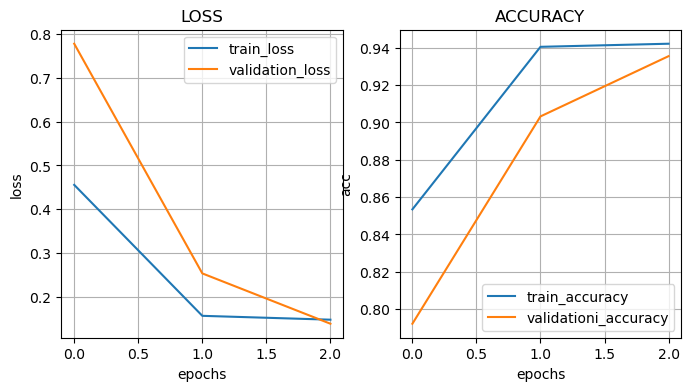

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 경로 설정

# colab
# ROOT_DIR='/content'
# loocal
ROOT_DIR='content'

DATA_ROOT_DIR= os.path.join(ROOT_DIR, 'Chest_Xray_Pnemonia')
TRAIN_DATA_ROOT_DIR= os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR= os.path.join(DATA_ROOT_DIR, 'test')
VAL_DATA_ROOT_DIR_= os.path.join(VAL_DATA_ROOT_DIR, 'val')
### 데이터셋 가져오기

#### Colab
# from google.colab import drive

# drive.mount('/content/')

# shutil.copy(os.path.join('/content/MyDrive/ColabNotebooks/','archive (3).zip'), ROOT_DIR)

# if os.path.exists(DATA_ROOT_DIR):
#     shutil.rmtree(DATA_ROOT_DIR)
    
# with zipfile.ZipFile(os.path.join(ROOT_DIR, 'archive (3).zip'), 'r') as target_file:
#     target_file.extractall(DATA_ROOT_DIR)

#### PC
# if os.path.exists(DATA_ROOT_DIR):
#     shutil.rmtree(DATA_ROOT_DIR)

# with zipfile.ZipFile(os.path.join(ROOT_DIR, 'Chest_Xray_Pnemonia.zip'), 'r') as target_file:
#     target_file.extractall(DATA_ROOT_DIR)

### 정답 및 전체 데이터 갯수 확인

#### 훈련 데이터 갯수
list= os.listdir(TRAIN_DATA_ROOT_DIR)
for file in list:
    print(len(os.listdir(TRAIN_DATA_ROOT_DIR+'/'+file)))

train_label_name_list= os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))
          
#### 테스트 데이터 갯수

test_label_name_list= os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

### Image Shape 설정

IMG_WIDTH= 100 # Colab에선 224
IMG_HEIGHT= 100

### test, val 디렉토리의 모든 파일을 Training 동일 디렉토리로 move
print('===========train으로 MOVE============')
test_label_name_list= os.listdir(TEST_DATA_ROOT_DIR)
val_label_name_list= os.listdir(VAL_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    test_path= os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list= os.listdir(test_path)
    
    train_path= os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num=0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num=move_num+1
        
    print(str(move_num)+' is moved into '+label_name)

for label_name in val_label_name_list:
    val_path= os.path.join(VAL_DATA_ROOT_DIR, label_name)
    val_file_list= os.listdir(val_path)
    
    train_path= os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num=0
    for val_file in val_file_list:
        shutil.move(os.path.join(val_path, val_file), os.path.join(train_path, val_file))
        move_num=move_num+1
        
    print(str(move_num)+' is moved into '+label_name)

### move 완료된 Training 전체 데이터 갯수 확인
print('==========train 전체 데이터 갯수===============')
train_label_name_list= os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

### Shuffle 후 다시 Testing으로 move
print('=============재분배==============')
VAL_MOVE_RATIO= 0.2
TEST_MOVE_RATIO= 0.1

label_name_list= os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src= os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst= os.path.join(TEST_DATA_ROOT_DIR, label_name)
    
    train_data_file_list= os.listdir(src)
    
    print('==============================')
    print('total [%s] data file nums => [%s]'%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)
    print('train data shuffle is done!!')
    
    split_num= int(TEST_MOVE_RATIO *len(train_data_file_list))
    print('split_num=>', split_num)
    
    test_data_file_list= train_data_file_list[0:split_num]
    
    move_num=0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file), os.path.join(dst, test_data_file))
        move_num= move_num+1
        
    print('total move nums => ', move_num)
    print('============================')

for label_name in label_name_list:
    src= os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst= os.path.join(VAL_DATA_ROOT_DIR, label_name)
    
    train_data_file_list= os.listdir(src)
    
    print('==============================')
    print('total [%s] data file nums => [%s]'%(label_name, len(train_data_file_list)))
        
    split_num= int(VAL_MOVE_RATIO *len(train_data_file_list))
    print('split_num=>', split_num)
    
    val_data_file_list= train_data_file_list[0:split_num]
    
    move_num=0
    for val_data_file in val_data_file_list:
        shutil.move(os.path.join(src, val_data_file), os.path.join(dst, val_data_file))
        move_num= move_num+1
        
    print('total move nums => ', move_num)
    print('============================')

### ImageDataGenerator 를 이용하여 데이터 불러오기

train_data_gen= ImageDataGenerator(rescale= 1./255)
test_data_gen= ImageDataGenerator(rescale= 1./255)
val_data_gen= ImageDataGenerator(rescale=1./255)

train_generator= train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, 
                                                batch_size=32,
                                                color_mode='rgb',
                                                shuffle= True, 
                                                target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                class_mode='sparse')

test_generator= test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True, 
                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                              class_mode='sparse')

val_generator= test_data_gen.flow_from_directory(directory=VAL_DATA_ROOT_DIR, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True, 
                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                              class_mode='sparse')

print(train_generator.class_indices)
print(test_generator.num_classes)

# ### 32장의 이미지 확인
# - ImageDataGenerator를 통해 전달된 이미지 출력

# data, label= train_generator.next()
# print(data.shape, label.shape)
# print(label)

# plt.figure(figsize=(12,12))

# class_dict={0:'glioma_tumor', 1:'meningioma_tumor',  2:'no_tumor',3: 'pituitary_tumor'}

# for i in range(len(label)):
#     plt.subplot(4,8,i+1)
#     plt.axis('off')
#     plt.title(class_dict[label[i]])
#     plt.imshow(data[i])
    
# plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

pre_trained_model= MobileNet(weights='imagenet', include_top=False,
                            input_shape= (IMG_WIDTH, IMG_HEIGHT,3))
# pre_trained_model.summary()

model= Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4), metrics=['acc']) # colab: lr=2e-5

start_time= datetime.now()

result= model.fit(train_generator, epochs=3, validation_data=val_generator) # colab: epoch=30
end_time= datetime.now()
print('걸린시간: ', end_time - start_time)

# 걸린시간:  0:04:33.357706
# 19/19 [==============================] - 10s 517ms/step - loss: 0.1302 - acc: 0.9402

#### 그래프
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

In [46]:
print(model.evaluate(test_generator))

test_simple_datagen= ImageDataGenerator(rescale= 1./255)

test_simple_generator= test_simple_datagen.flow_from_directory(directory=VAL_DATA_ROOT_DIR, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True, 
                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                              class_mode='sparse')

print(model.evaluate(test_simple_generator))

# 19/19 [==============================] - 6s 303ms/step - loss: 0.1302 - acc: 0.9402
# Found 1054 images belonging to 2 classes.
# 33/33 [==============================] - 11s 326ms/step - loss: 0.1393 - acc: 0.9355
# [0.139250710606575, 0.9354838728904724]

19/19 [==============================] - 6s 303ms/step - loss: 0.1302 - acc: 0.9402
Found 1054 images belonging to 2 classes.
33/33 [==============================] - 11s 326ms/step - loss: 0.1393 - acc: 0.9355


[0.139250710606575, 0.9354838728904724]

# 